In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

/Users/kushalgoenka/anaconda3/envs/CS498AML/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Hierarchical KMeans Algorithm for Two Layers##

This is the Hierarchical KMeans function that was custom built to enable two different Layers. The input it takes is the number of clusters in each of the two layers, and this can be easily customized. This was done as the KMeans in the sklearn library didn't include this/I couldn't find something like this.

In [2]:
class HierarchicalKMeans():
    def __init__(self,numfirstlayer=40,numsecondlayer=12):
        self.first = numfirstlayer
        self.second = numsecondlayer
        self.clusters = 0
        
    def fit(self,data):
        self.data = data
        kmeans1 = KMeans(n_clusters=self.first).fit(data)
        labelslayer1 = kmeans1.labels_
        secondlayermodels=[]
        for i in range(0,self.first):
            flag = labelslayer1==i
            subsection = reshapeddata[flag]
            kmeans2 = KMeans(n_clusters=self.second).fit(subsection)
            secondlayermodels.append(kmeans2)
        self.secondmodels = secondlayermodels
        self.first_model = kmeans1

    def predict(self,data):
        model = self.first_model
        prediction = model.predict(data)
        predict=[]
        for idx,p in enumerate(prediction,0):
            currentmodel = self.secondmodels[p]
            num = int(currentmodel.predict(data[idx].reshape(1,-1)))
            predict.append(p*12+num)
        return np.array(predict)

## Functions to Read the data ##

In [3]:
def filetoDataframe(folderName):
    filenames= glob.glob("HMP_Dataset/"+folderName+"/*.txt")
    df_lists = [pd.read_csv(filename,sep=" ",header=None) for filename in filenames]
    combined_df = pd.concat(df_lists, ignore_index=True)
    return combined_df

#  Returns a dictionary with all the files split into corresponding values
# as different Arrays
def signaltoDataframe(folderNames):
    fileDict = {}
    for folderName in folderNames:
        filenames= glob.glob("HMP_Dataset/"+folderName+"/*.txt")
        df_lists = [np.array(pd.read_csv(filename,sep=" ",header=None)) for filename in filenames]
        fileDict[folderName] = np.array(df_lists)
    return fileDict

def combinedData(folders):
    activities = {}
    for folder in folders:
        activities[folder] = filetoDataframe(folder)
    alldfs = []
    for activity in activities.keys():
        alldfs.append(activities[activity])
    # Combined data of all the activities and corresponding 3 axis data
    combined_df = pd.concat(alldfs,ignore_index=True)
    alldata = np.array(combined_df)
    return alldata
    

def resized(alldata,numsamp=32):
    mod = alldata.shape[0]%numsamp
    alldata = alldata[:alldata.shape[0]-mod]
    numnew = alldata.shape[0]/numsamp
    newdata = np.array(np.vsplit(alldata,numnew))
    reshapeddata = np.zeros((int(numnew),3*numsamp))
    for i in range(0,newdata.shape[0]):
        reshapeddata[i] = newdata[i].flatten()
    return reshapeddata



## Generating the Histogram Feature Representation##

In [ ]:
def generateFeatures(folders,model=None,size=32,clusters=0):
    dic = signaltoDataframe(folders)
    X = []
    Y = []
    Rarray =[]
    for labeli,fold in enumerate(dic.keys(),0):
        for file in dic[fold]:
            filedata = resized(file,size)
            array = model.predict(filedata)
            X.append(array)
            Y.append(labeli)
    for row in X:
        r = np.histogram(row,bins=np.arange(clusters))
        Rarray.append(np.array(r[0]))
    return Rarray,Y,X

## Procedure to Evaluate the Dataset ##

This stores all the folder names in the dataset to further parse it in the future. Each folder represents one activity and hence can be labelled accordingly.

In [4]:
folders = ["Brush_teeth","Climb_stairs","Comb_hair","Descend_stairs","Drink_glass","Eat_meat","Eat_soup","Getup_bed","Liedown_bed","Pour_water","Sitdown_chair","Standup_chair","Use_telephone","Walk"]

Training the Vector Quantization and conducting the KMeans algorithm to create clusters.

In [5]:
sizeofsample = 15 #Here sample size *3 gives us the length (X,Y,Z)
firstLayer = 40
secondLayer = 12
numCluster = firstLayer*secondLayer

alldata = combinedData(folders)
reshapeddata = resized(alldata,sizeofsample)

means = HierarchicalKMeans(firstLayer,secondLayer)
means.fit(reshapeddata)

Create a Histogram of the Data which are the new feature vectors

In [6]:
X,Y,notHist = generateFeatures(folders,means,sizeofsample,numCluster)
featureDf = pd.DataFrame(X)
featureDfnorm = featureDf.div(featureDf.sum(axis=1), axis=0)

Train the Multiclass classifier, Here I used a RandomForest Classifier to predict the different classes.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(featureDfnorm, Y, test_size=0.10)
clf = RandomForestClassifier(n_estimators = 70,max_depth = 45)
clf.fit(X_train,y_train)
print("Train Score",clf.score(X_train,y_train))
print("Test Score",clf.score(X_test,y_test))

Train Score 1.0
Test Score 0.7619047619047619


The following provides a way to visualize each activity and the type of histogram that it would produce.

In [9]:
featurearray = np.array(featureDfnorm)
Y = np.array(Y).flatten()

meanquantized = []

# print(Y[0]==0)
for i in range(0,14):
#     print(i)
    flag = i==Y
#     print(flag.shape)
    subset = featurearray[flag]
    print(subset.shape)
    mean = np.mean(subset, axis=0)
    meanquantized.append(mean)
    

(12, 479)
(102, 479)
(31, 479)
(42, 479)
(100, 479)
(5, 479)
(3, 479)
(101, 479)
(28, 479)
(100, 479)
(100, 479)
(102, 479)
(13, 479)
(100, 479)


/Users/kushalgoenka/anaconda3/envs/CS498AML/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


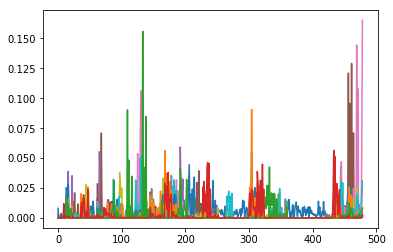

In [10]:
plt.figure()
plt.subplot()
for i in range(np.shape(meanquantized)[0]):
    plt.subplot()
    plt.plot(meanquantized[i])
# plt.plot(meanquantized[1])

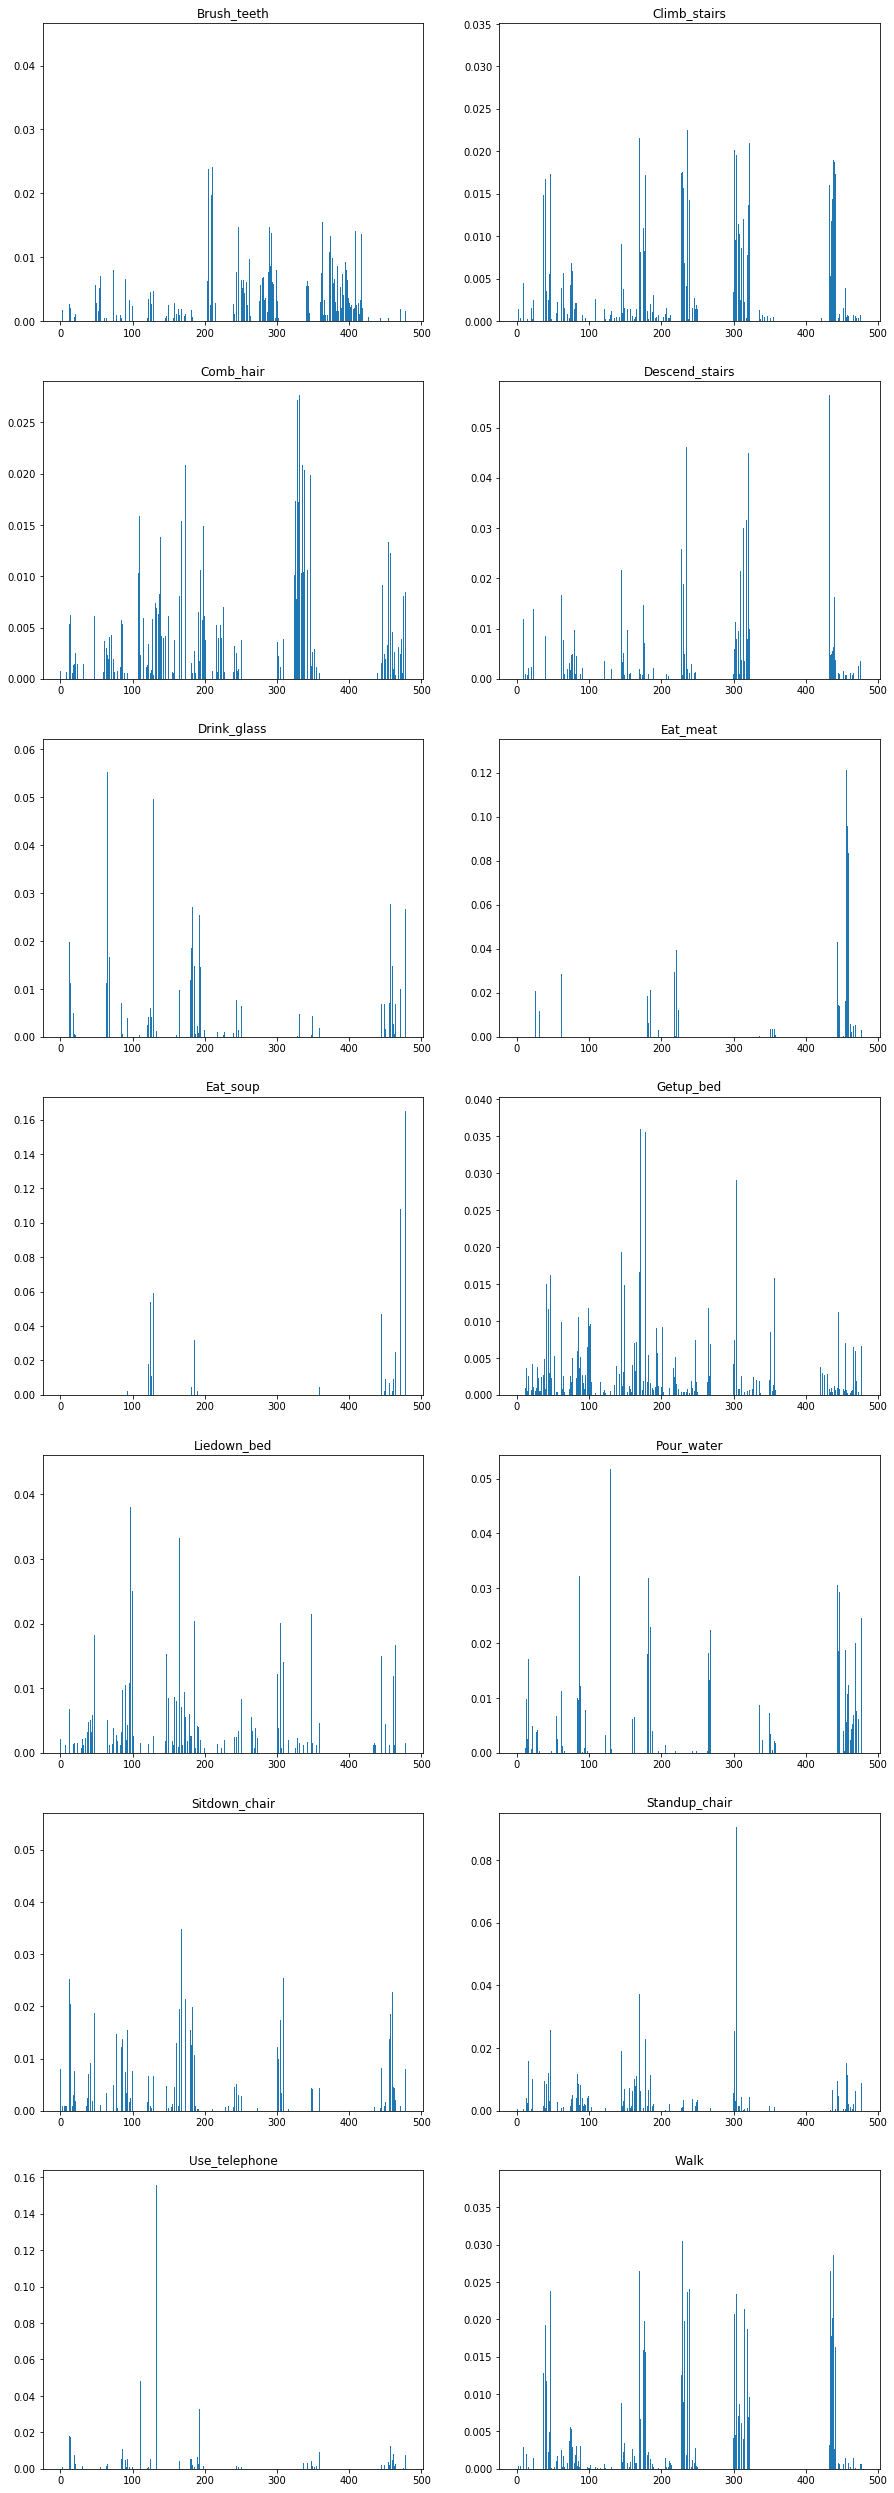

In [24]:
fig, axs = plt.subplots(7,2, figsize=(15, 45))
axs = axs.ravel()

for i in range(14):

    axs[i].bar(np.arange(0,479),meanquantized[i])
    axs[i].set_title(folders[i])

Print the Confusion Matrix

In [25]:
prediction = clf.predict(featureDf)
ConfusionMatrix = confusion_matrix(prediction,Y)
print(ConfusionMatrix)

[[ 10   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  98   0   0   0   0   0   0   0   0   0   0   0  23]
 [  0   0  27   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  42   0   0   0   0   0   0   0   0   0   0]
 [  0   2   4   0 100   0   0   2   0   0   0   0   4   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  82   1   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0  21   0   0   0   0   0]
 [  2   0   0   0   0   5   2   1   1  99   1   0   3   0]
 [  0   0   0   0   0   0   0   1   1   0  90   1   0   1]
 [  0   0   0   0   0   0   0  15   4   1   9 100   0   2]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0]
 [  0   2   0   0   0   0   0   0   0   0   0   0   0  74]]


In [36]:
cm = pd.DataFrame(ConfusionMatrix,columns=folders)
# cm = cm.set_index(keys=folders)

In [40]:
rows={}
for i in range(0,14):
    rows[i]=folders[i]
cm = cm.rename(rows,axis='index')

cm.to_csv('ConfusionMatrix.csv')

USING THE KMEANS OF THE SKLEARN PACKAGE

In [38]:
sizeofsample = 50
firstLayer = 40
secondLayer = 12
numCluster = firstLayer*secondLayer

alldata = combinedData(folders)
reshapeddata = resized(alldata,sizeofsample)
model1 = KMeans(n_clusters=numCluster).fit(reshapeddata)

In [39]:
X,Y = generateFeatures(folders,model1,sizeofsample,numCluster)

In [41]:
featureDf = pd.DataFrame(X)
featureDfnorm = featureDf.div(featureDf.sum(axis=1), axis=0)
X_train, X_test, y_train, y_test = train_test_split(featureDf, Y, test_size=0.10)
clf = RandomForestClassifier(n_estimators = 35,max_depth = 25)
clf.fit(X_train,y_train)
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))

0.9880794701986755
0.5952380952380952


In [42]:
prediction = clf.predict(featureDf)
ConfusionMatrix = confusion_matrix(prediction,Y)
print(ConfusionMatrix)

[[ 11   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 100   0   1   0   0   0   1   0   0   0   0   0   5]
 [  0   0  28   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  40   0   0   0   0   0   0   0   0   0   0]
 [  1   1   3   0  98   0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   0   4   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   3   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0  97   0   0   0   2   0   0]
 [  0   0   0   0   0   0   0   0  25   0   0   0   0   0]
 [  0   0   0   0   1   1   0   3   0  96   0   0   0   0]
 [  0   0   0   1   1   0   0   0   3   3  98   9   0   3]
 [  0   0   0   0   0   0   0   0   0   0   2  91   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  13   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  92]]


    DOING EVERYTHING TOGETHER IN ONE CODECELL FOR REPRODUCTION PURPOSES (Hierarchical)
    

In [ ]:
samplesizes = [10,15,20,25,30,35,40,45]

sizeofsample = 10 #Here sample size *3 gives us the length (X,Y,Z)

for sizeofsample in samplesizes:

    firstLayer = 40
    secondLayer = 12
    numCluster = firstLayer*secondLayer

    alldata = combinedData(folders)
    reshapeddata = resized(alldata,sizeofsample)

    means = HierarchicalKMeans(firstLayer,secondLayer)
    means.fit(reshapeddata)

    X,Y = generateFeatures(folders,means,sizeofsample,numCluster)
    featureDf = pd.DataFrame(X)
    featureDfnorm = featureDf.div(featureDf.sum(axis=1), axis=0)

    X_train, X_test, y_train, y_test = train_test_split(featureDfnorm, Y, test_size=0.10)
    clf = RandomForestClassifier(n_estimators = 30,max_depth = 15)
    clf.fit(X_train,y_train)
    print("SampleSize:",sizeofsample)
    print("Train Score",clf.score(X_train,y_train))
    print("Test Score",clf.score(X_test,y_test))
    print()

GENERAL KMEANS

In [8]:
clusters = [350,370,390,410,430,450,470,490]
sizeofsample = 32
alldata = combinedData(folders)
reshapeddata = resized(alldata,sizeofsample)

for numCluster in clusters:

    model1 = KMeans(n_clusters=numCluster).fit(reshapeddata)
    X,Y = generateFeatures(folders,model1,sizeofsample,numCluster)
    featureDf = pd.DataFrame(X)
    featureDfnorm = featureDf.div(featureDf.sum(axis=1), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(featureDfnorm, Y, test_size=0.10)
    clf = RandomForestClassifier(n_estimators = 35,max_depth = 25)
    clf.fit(X_train,y_train)
    print("Cluster Size:",numCluster)
    print("Train Score",clf.score(X_train,y_train))
    print("Test Score",clf.score(X_test,y_test))
    print()

Cluster Size: 350
Train Score 0.9668874172185431
Test Score 0.7380952380952381

Cluster Size: 370
Train Score 0.9562913907284768
Test Score 0.7261904761904762

Cluster Size: 390
Train Score 0.9655629139072848
Test Score 0.7261904761904762

Cluster Size: 410
Train Score 0.9602649006622517
Test Score 0.7619047619047619

Cluster Size: 430
Train Score 0.952317880794702
Test Score 0.6904761904761905

Cluster Size: 450
Train Score 0.9602649006622517
Test Score 0.6785714285714286

Cluster Size: 470
Train Score 0.9668874172185431
Test Score 0.75

Cluster Size: 490
Train Score 0.9536423841059603
Test Score 0.75

